# Glassdoor Data Science Job Posting - ETL + Data Analysis Project

This notebook builds a reproducible ETL pipeline that transforms raw Glassdoor Data Science job postings into an analytics-ready dataset and explores how skills, seniority, location, and sector relate to compensation. 

In [31]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv("Uncleaned_DS_jobs.csv")


In [32]:
df.head()
df.shape
df.columns
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              672 non-null    int64  
 1   Job Title          672 non-null    object 
 2   Salary Estimate    672 non-null    object 
 3   Job Description    672 non-null    object 
 4   Rating             672 non-null    float64
 5   Company Name       672 non-null    object 
 6   Location           672 non-null    object 
 7   Headquarters       672 non-null    object 
 8   Size               672 non-null    object 
 9   Founded            672 non-null    int64  
 10  Type of ownership  672 non-null    object 
 11  Industry           672 non-null    object 
 12  Sector             672 non-null    object 
 13  Revenue            672 non-null    object 
 14  Competitors        672 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 78.9+ KB


index                0
Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         0
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
dtype: int64

In [33]:
df["Salary Estimate"].head()

0    $137K-$171K (Glassdoor est.)
1    $137K-$171K (Glassdoor est.)
2    $137K-$171K (Glassdoor est.)
3    $137K-$171K (Glassdoor est.)
4    $137K-$171K (Glassdoor est.)
Name: Salary Estimate, dtype: object

# Salary Parsing

In [34]:
def parse_salary(s):
    s = str(s)

    s = re.sub(r"\(.*?\)", "", s)

    s = s.replace("$", "").replace("K", "").strip()

    try:
        low, high = s.split("-")
        low, high = int(low), int(high)
        return low, high, (low + high) / 2
    except:
        return np.nan, np.nan, np.nan


In [35]:
df[["min_salary_k", "max_salary_k", "avg_salary_k"]] = (df["Salary Estimate"].apply(lambda x: pd.Series(parse_salary(x))))

salary_cols = ["min_salary_k", "max_salary_k", "avg_salary_k"] 

for col in salary_cols:
    df[col] = df[col].astype(int)
    

In [36]:
df[["min_salary_k", "max_salary_k", "avg_salary_k"]].head()

,min_salary_k,max_salary_k,avg_salary_k
0,137,171,154
1,137,171,154
2,137,171,154
3,137,171,154
4,137,171,154


In [37]:
df["avg_salary_k"].describe()

count    672.000000
mean     123.476190
std       39.596166
min       43.000000
25%      103.000000
50%      114.000000
75%      136.000000
max      271.000000
Name: avg_salary_k, dtype: float64

In [38]:
def parse_salary_range(s):
    low, high, _ = parse_salary(s)
    if pd.isna(low) or pd.isna(high):
        return np.nan
    return f"{int(low)}-{int(high)}"

df["Salary Estimate"] = df["Salary Estimate"].apply(parse_salary_range)


## Salary Parsing Summary

- The `Salary Estimate` column contained unstructured text values such as "$137K-$171K (Glassdoor est.)". I extracted the minimum, maximum, and average salary values by removing text annotations, parsing numeric ranges, and converting the results to numeric features suitable for analysis.

- After parsing the salary ranges into numeric features, I validated the results using summary statistics to ensure values were reasonable and free of parsing
errors. The distribution of average salaries aligned with the expected market ranges for data science roles.

- I also reused the salary parsing function to standardize the original salary text into a clean numeric range while keeping min, max, and average salary features.


# Company Name Cleaning

In [39]:
df["Company Name"].head(10)


0           Healthfirst\n3.1
1               ManTech\n4.2
2        Analysis Group\n3.8
3               INFICON\n3.5
4    Affinity Solutions\n2.9
5           HG Insights\n4.2
6              Novartis\n3.9
7                iRobot\n3.5
8         Intuit - Data\n4.4
9    XSELL Technologies\n3.6
Name: Company Name, dtype: object

In [40]:
def clean_company(name):
    return str(name).split("\n")[0].strip()

df["company_clean"] = df["Company Name"].apply(clean_company)

# Replace with cleaned version
df = df.drop(columns=["Company Name"], errors="ignore")
df = df.rename(columns={"company_clean": "Company Name"})

df[["Company Name"]].head()

,Company Name
0,Healthfirst
1,ManTech
2,Analysis Group
3,INFICON
4,Affinity Solutions


## Company Name Cleaning Summary

Company names contained embedded ratings separated by newline characters. I extracted clean company names by removing the rating component and standardizing whitespace for improved readability.


# Standardizing Location Format

In [41]:
df["Location"].head(20)

0          New York, NY
1         Chantilly, VA
2            Boston, MA
3            Newton, MA
4          New York, NY
5     Santa Barbara, CA
6         Cambridge, MA
7           Bedford, MA
8         San Diego, CA
9           Chicago, IL
10          Herndon, VA
11      Saint Louis, MO
12         Richland, WA
13       Northbrook, IL
14       Washington, DC
15       Washington, DC
16               Remote
17          Memphis, TN
18            Plano, TX
19       West Grove, PA
Name: Location, dtype: object

In [42]:
# Accounts for non-standard rows

us_state_to_abbrev = {
    "Alabama":"AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA","Colorado":"CO",
    "Connecticut":"CT","Delaware":"DE","Florida":"FL","Georgia":"GA","Hawaii":"HI","Idaho":"ID",
    "Illinois":"IL","Indiana":"IN","Iowa":"IA","Kansas":"KS","Kentucky":"KY","Louisiana":"LA",
    "Maine":"ME","Maryland":"MD","Massachusetts":"MA","Michigan":"MI","Minnesota":"MN",
    "Mississippi":"MS","Missouri":"MO","Montana":"MT","Nebraska":"NE","Nevada":"NV",
    "New Hampshire":"NH","New Jersey":"NJ","New Mexico":"NM","New York":"NY","North Carolina":"NC",
    "North Dakota":"ND","Ohio":"OH","Oklahoma":"OK","Oregon":"OR","Pennsylvania":"PA",
    "Rhode Island":"RI","South Carolina":"SC","South Dakota":"SD","Tennessee":"TN","Texas":"TX",
    "Utah":"UT","Vermont":"VT","Virginia":"VA","Washington":"WA","West Virginia":"WV",
    "Wisconsin":"WI","Wyoming":"WY"
}

def parse_location_modified(loc):
    loc = str(loc).strip()
    if loc.lower() == "remote":
        return None, None, 1, "remote"
    elif "," in loc:
        city, state = loc.split(",", 1)
        return city.strip(), state.strip(), 0, "city_state"
    elif loc.lower() == "united states":
        return None, None, 0, "country_only"
    elif loc in us_state_to_abbrev:
        return None, us_state_to_abbrev[loc], 0, "state_only"

    return None, None, 0, "unknown"


In [43]:
df[["city", "state", "is_remote", "location_level"]] = (
    df["Location"].apply(lambda x: pd.Series(parse_location_modified(x)))
)
df["location_level"].value_counts()


location_level
city_state      649
country_only     11
remote            6
state_only        6
Name: count, dtype: int64

In [44]:
df[["city", "state", "is_remote", "location_level"]].iloc[89:101]

,city,state,is_remote,location_level
89,None,None,0,country_only
90,Gaithersburg,MD,0,city_state
91,Springfield,VA,0,city_state
92,Alexandria,VA,0,city_state
93,None,UT,0,state_only
94,Washington,DC,0,city_state
95,San Diego,CA,0,city_state
96,Reston,VA,0,city_state
97,New York,NY,0,city_state
98,Denver,CO,0,city_state


## Location Parsing Summary

The `Location` field contained mixed and non-standard formats, including city-state pairs (e.g., Atlanta, GA), state-only values (e.g., Texas), country-only values (e.g., United States), and remote roles.

To standardize the mixed and non-standard fields, I modified my original parsing function to include logic that:
- Extracts city and state values when a city-state pattern is present
- Maps full U.S. state names to their two-letter abbreviations for consistency
- Identifies and flags remote roles using a numeric `is_remote` indicator
- Classifies each record using a `location_level` feature (`city_state`, `state_only`, `country_only`, `remote`, `unknown`) to preserve semantic meaning

This approach ensures geographic information is standardized without introducing assumptions, while retaining flexibility for downstream analysis and visualization.


# Skill Extraction from Job Descriptions


In [45]:
df["Job Description"].iloc[0] # Preview

"Description\n\nThe Senior Data Scientist is responsible for defining, building, and improving statistical models to improve business processes and outcomes in one or more healthcare domains such as Clinical, Enrollment, Claims, and Finance. As part of the broader analytics team, Data Scientist will gather and analyze data to solve and address complex business problems and evaluate scenarios to make predictions on future outcomes and work with the business to communicate and support decision-making. This position requires strong analytical skills and experience in analytic methods including multivariate regressions, hierarchical linear models, regression trees, clustering methods and other complex statistical techniques.\n\nDuties & Responsibilities:\n\n• Develops advanced statistical models to predict, quantify or forecast various operational and performance metrics in multiple healthcare domains\n• Investigates, recommends, and initiates acquisition of new data resources from interna

In [46]:
skills = {
    "python" : r"\bpython\b",
    "sql": r"\bsql\b",
    "excel": r"\bexcel\b",
    "tableau": r"\btableau\b",
    "power_bi": r"\bpower\s?bi\b",
    "r": r"\br\b",
    "aws": r"\baws\b",
    "spark": r"\bspark\b",
}

for skill, pattern in skills.items():
    df[f"req_{skill}"] = (df["Job Description"].str.contains(pattern, case=False, na=False, regex=True).astype(int))


In [47]:
skill_cols = []

for c in df.columns:
    if c.startswith("req_"):
        skill_cols.append(c)

df[skill_cols].head()
df[skill_cols].mean()

req_python      0.727679
req_sql         0.483631
req_excel       0.116071
req_tableau     0.183036
req_power_bi    0.071429
req_r           0.467262
req_aws         0.200893
req_spark       0.266369
dtype: float64

In [48]:
df["skill_count"] = df[skill_cols].sum(axis=1)
df["skill_count"].describe()


count    672.000000
mean       2.516369
std        1.581290
min        0.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        7.000000
Name: skill_count, dtype: float64

## Skill Extraction Summary

The job descriptions contained unstructured text that could not be analyzed directly using traditional tabular methods. To address this, I extracted key technical skills from the Job Description field using regular expression–based pattern matching.

For each selected skill (e.g., Python, SQL, Excel, Tableau, AWS), I created a binary indicator column (req_<skill>) that flags whether the skill is mentioned in the job description. Word boundary patterns were used to minimize false positives and ensure accurate matching.

In addition, I engineered a `"skill_count"` feature by summing all skill indicators per job, representing the breadth of technical requirements for each role. These structured features enable downstream analysis of skill demand, salary comparisons, and role complexity while preserving interpretability.


# Seniority Extraction from Job Title

In [49]:
def seniority(title):
    t = str(title).lower()

    if any(x in t for x in ["lead", "manager", "head", "director"]):
        return "Lead/Manager"

    if (any(x in t for x in ["senior", "expert", "principal", "staff"]) or re.search(r"\bsr\b", t)):
        return "Senior"

    if re.search(r"\bii\b", t):
        return "Mid-Level"

    if re.search(r"\bi\b", t):
        return "Entry"

    if any(x in t for x in ["experienced", "associate", "mid"]):
        return "Mid-Level"

    if any(x in t for x in ["early", "graduate", "entry", "junior", "jr"]):
        return "Entry"

    return "Unknown"


In [50]:
df["seniority"] = df["Job Title"].apply(seniority)
df["seniority"].value_counts()


seniority
Unknown         547
Senior           92
Lead/Manager     17
Mid-Level        10
Entry             6
Name: count, dtype: int64

## Seniority Classification Summary

Job titles contained a wide variety of seniority indicators (e.g., "early career", "experienced", "Senior", "Staff", "Manager", Roman numerals such as I and II). To standardize these variations, I applied rule-based keyword matching to normalize job listings into a small set of interpretable seniority categories.

Leadership titles (e.g., Lead, Manager, Director) were prioritized over experience-based titles to reflect organizational responsibility. Roman numerals were interpreted as role progression indicators, with level I mapped to entry-level roles and level II mapped to mid-level roles. Advanced individual contributor titles (e.g., Senior, Staff, Principal) were grouped under a senior category.

This standardized seniority feature enables meaningful analysis of compensation, skill requirements, and role progression while preserving interpretability.


# Validation Checks

### Salary by Skill

In [51]:
df.groupby("req_power_bi")["avg_salary_k"].agg(["mean", "count"])

,mean,count
req_power_bi,,
0,123.352564,624
1,125.083333,48


### Interpretation

- Roles that mentioned Power BI showed a slightly higher average salary than roles that did not. However, the difference was small and the Power BI group represented a much smaller portion of the dataset, suggesting that Power BI functions more as a complementary skill rather than a primary driver of compensation.

### Salary by Remote vs In-person

In [52]:
df.groupby("is_remote")["avg_salary_k"].agg(["mean", "count"])

,mean,count
is_remote,,
0,123.489489,666
1,122.000000,6


### Interpretation

- In this dataset, remote roles showed an average salary similiar to in-person roles. However, the number of remote postings was very small, limiting the reliability of any conclusions about salary differences between remote and in-person positions

### Salary by Job Sector

In [53]:
df["Sector"] = df["Sector"].replace("-1", "Other")
df.groupby("Sector")["avg_salary_k"].agg(["mean", "count"]) \
  .query("count >= 10") \
  .sort_values("mean")


,mean,count
Sector,,
"Oil, Gas, Energy & Utilities",101.000000,10
Insurance,111.125000,32
Finance,115.303030,33
Information Technology,118.728723,188
Health Care,119.571429,21
Biotech & Pharmaceuticals,122.621212,66
Manufacturing,123.043478,23
Other,129.535211,71
Business Services,129.883333,120


### Interpretation

- Average salaries varied meaningfully across sectors. Government, Aerospace & Defense, and Business Services showed the highest average salary, while Oil, Gas, Energy & Utilities and Insurance showed lower salaries. Technology and life science–related sectors (e.g., Information Technology, Biotech & Pharmaceuticals) fell in the middle range, reflecting competitive but diverse compensation ranges across roles and companies.

### Salary by Seniority

In [54]:
df.groupby("seniority")["avg_salary_k"].agg(["mean", "count"])

,mean,count
seniority,,
Entry,111.000000,6
Lead/Manager,136.588235,17
Mid-Level,129.100000,10
Senior,120.717391,92
Unknown,123.566728,547


### Interpretation

- Average salary generally increased with seniority, with leadership roles exhibiting the highest compensation. However, mid-level and senior roles showed substantial overlap in average pay, reflecting variation across industries, companies, and job title conventions. A large portion of roles fell into the “Unknown” category, indicating that seniority is not always explicitly stated in job titles.

### Salary by Number of Skills Needed

In [55]:
df.groupby("skill_count")["avg_salary_k"].agg(["mean", "count"])

,mean,count
skill_count,,
0,127.674419,86
1,124.378641,103
2,116.081481,135
3,126.239264,163
4,121.685950,121
5,131.422222,45
6,106.307692,13
7,152.833333,6


### Interpretation

- Salary did not increase linearly with the number of required skills. Roles requiring a moderate to high number of skills (e.g., 3–5 skills) tended to offer higher average compensation, while roles with very few or very many listed skills showed greater variability. Categories with extremely high skill counts had small sample sizes, limiting the reliability of those averages.

### Salary by Seniority x Skill Count

In [56]:
df.groupby(["seniority", "skill_count"])["avg_salary_k"].agg(["mean", "count"])

mean  count
seniority    skill_count                   
Entry        0            115.000000      4
             1            103.000000      2
Lead/Manager 0            177.000000      6
             2            101.666667      3
             3            105.000000      1
             4            121.666667      6
             6            120.000000      1
Mid-Level    0            134.000000      2
             1            151.000000      2
             3            108.500000      4
             5            143.500000      2
Senior       0            119.928571     14
             1            121.818182     11
             2            112.157895     19
             3            128.714286     21
             4            121.826087     23
             6            112.750000      4
Unknown      0            125.183333     60
             1            124.579545     88
             2            117.123894    113
             3            126.532847    137
             4            121.652174     92
             5            130.860465     43
             6            101.375000      8
             7            152.833333      6

### Interpretation

- The relationship between skill range and salary varied by seniority level. For mid-level and senior roles, job listings requiring a moderate number of skills (approximately 3–5) tended to offer higher average compensation, suggesting that well-defined, skill-balanced roles are most highly valued. At both low and very high skill counts, average salaries were more volatile, largely due to small sample sizes. This indicates that skill range influences compensation differently across seniority levels and should be interpreted in context rather than in isolation.

## Average Salary by Seniority Graph Visualization 

<Axes: title={'center': 'Average Salary by Seniority'}, xlabel='seniority'>

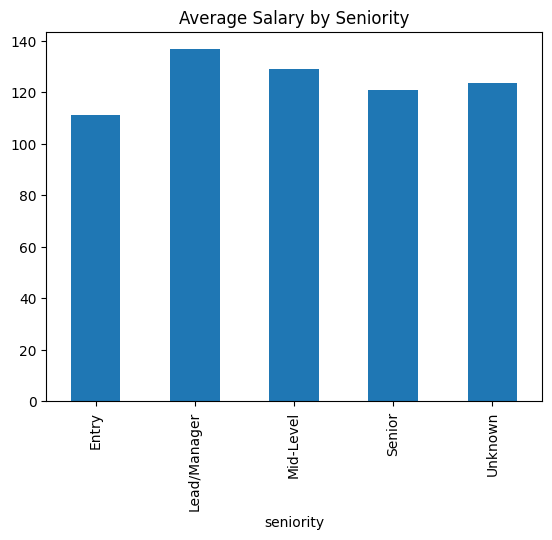

In [57]:
df.groupby("seniority")["avg_salary_k"].mean().plot(kind="bar", title="Average Salary by Seniority")


Visualization shows mean salaries only; sample size considerations are discussed in the validation section above.

## Key Insights

- Leadership roles (Lead/Manager) showed the highest average salaries, highlighting the strong relationship between organizational responsibility and compensation. In contrast, mid-level and senior roles showed overlapping salary ranges, reflecting variation across industries and job title naming conventions.

- Individual technical skills (e.g., Power BI) were associated with only marginal salary differences. This suggests that single tools function as complementary requirements rather than primary drivers of compensation.

- Remote roles demonstrated average salaries comparable to in-person roles; however, the very small number of fully remote postings limited the reliability of conclusions regarding location-based pay differences.

- Compensation varied meaningfully across sectors. Government, Aerospace & Defense, and Business Services offered higher average salaries, while Insurance and Energy-related sectors trended lower. Technology and life science sectors fell within a competitive middle range.

- Salary did not increase linearly with the number of required technical skills. Roles requiring a moderate number of skills (approximately 3–5) tended to offer higher compensation, while extreme skill counts showed greater variability driven by small sample sizes.

- The relationship between skill range and salary differed by seniority level. For mid-level and senior roles, balanced skill requirements were associated with higher pay, whereas leadership roles exhibited weaker dependence on technical skill range, emphasizing responsibility over specific tool expertise.


In [58]:
# Drop Unused Columns
df = df.drop(columns=["index"], errors="ignore")
df = df.drop(columns=["Competitors"], errors="ignore")
df = df.drop(columns=["Founded"], errors="ignore")

In [59]:
# Reorder columns
front = [
    "Job Title",
    "Company Name",
    "Rating",
    "Job Description",
    "Salary Estimate",
    "min_salary_k",
    "max_salary_k",
    "avg_salary_k",
]

remaining = [c for c in df.columns if c not in front]
df = df[front + remaining]

In [60]:
df.to_csv("job_market_cleaned.csv", index=False)